# Load Libraries

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import requests,io
#import cv2
#import astroalign
import math
from astropy.io import fits
from astropy.stats import sigma_clipped_stats,gaussian_sigma_to_fwhm, SigmaClip
from astropy.table import QTable
from astropy.utils.exceptions import AstropyDeprecationWarning


from photutils.background import LocalBackground, MMMBackground,Background2D,MedianBackground
from photutils.detection import DAOStarFinder
from photutils.psf import PSFPhotometry, IterativePSFPhotometry, IntegratedGaussianPRF,prepare_psf_model, IterativelySubtractedPSFPhotometry, DAOGroup, SourceGrouper

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


# Load the reduced data

In [4]:
data_path = 'data/reduced/'

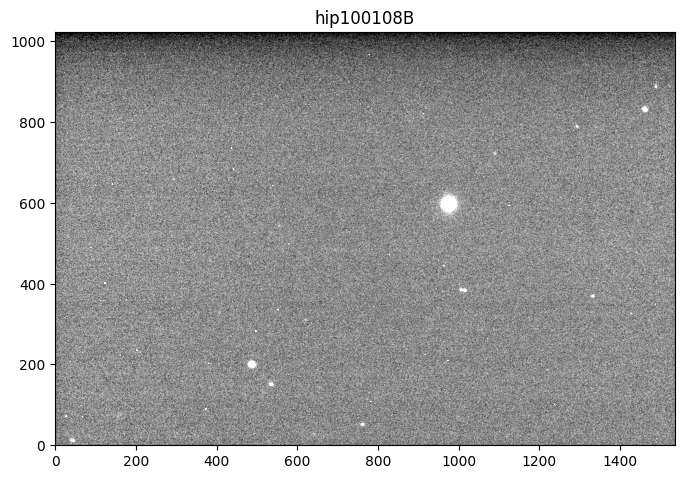

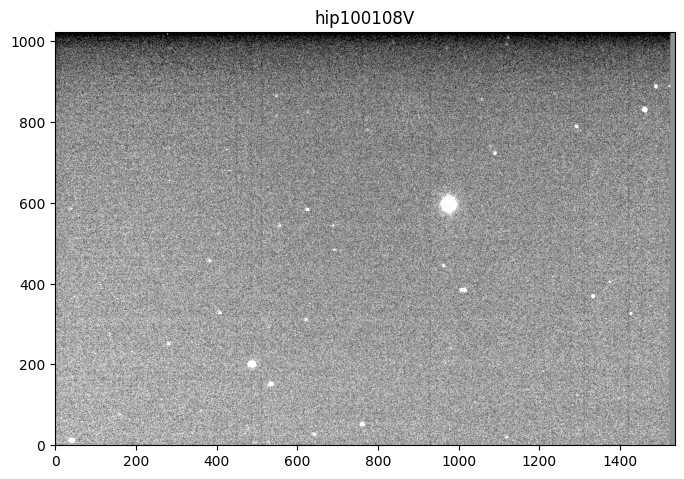

In [5]:
data = {}
data["hip100108B"] = np.load(f'{data_path}/hip100108B.npy')
data["hip100108V"] = np.load(f'{data_path}/hip100108G.npy')
#data["hip100108V"] =datahip100108V[0]


lo,up= np.percentile(data["hip100108B"],1),np.percentile(data["hip100108B"],99)
plt.figure(figsize=(8, 8))
plt.imshow(data["hip100108B"], cmap='gray', origin='lower', clim=(lo,up))
plt.title(f"hip100108B")
plt.show()

lo,up= np.percentile(data["hip100108V"],1),np.percentile(data["hip100108V"],99)
plt.figure(figsize=(8, 8))
plt.imshow(data["hip100108V"], cmap='gray', origin='lower', clim=(lo,up))
plt.title(f"hip100108V")
plt.show()

In [18]:
error = {}
error["hip100108B"] = np.load(f'{data_path}/hip100108B_error.npy')
error["hip100108V"] = np.load(f'{data_path}/hip100108B_error.npy')

# Background Estimation

In [6]:
for key, image in data.items():
    print(image.shape)

(1024, 1536)
(1024, 1536)


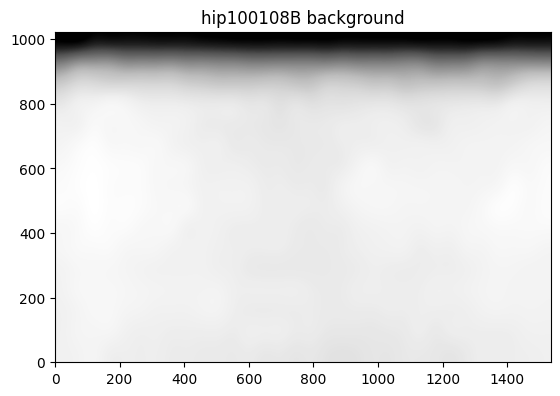

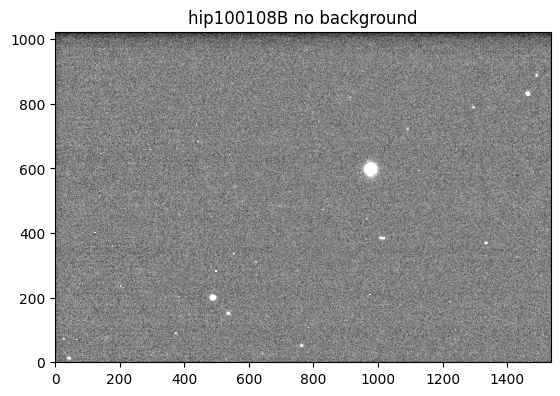

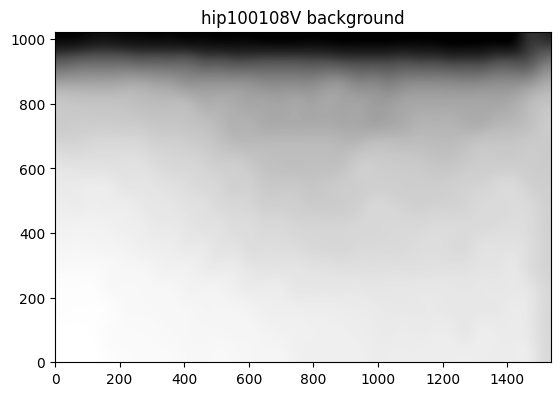

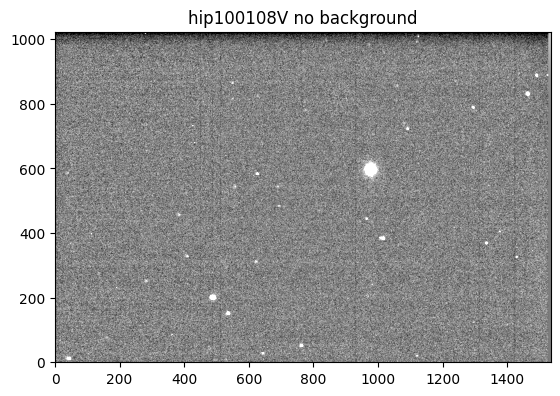

In [7]:
bkgs={}
bkg_uncs = {}
images_nobkg={}
for key, image in data.items():
    sigma_clip = SigmaClip(sigma=3.0)
    bkg_estimator = MedianBackground()
    bkg = Background2D(image,
                       (64,48), #they say it works better if data is covered by int nb of boxes
                       filter_size=(3,3),sigma_clip=sigma_clip,
                    bkg_estimator=bkg_estimator)
    bkgs[key] = bkg.background
    bkg_uncs[key] = bkg.background_rms
    plt.title(f'{key} background')
    plt.imshow(bkg.background, origin='lower', cmap='Greys_r')
    plt.show()

    images_nobkg[key]=image-bkg.background
    lo,up= np.percentile(images_nobkg[key],1),np.percentile(images_nobkg[key],99)
    plt.imshow(images_nobkg[key], cmap='gray', origin='lower', clim=(lo,up))
    plt.title(f'{key} no background')
    plt.show()

    data[key] = image - bkg.background





    

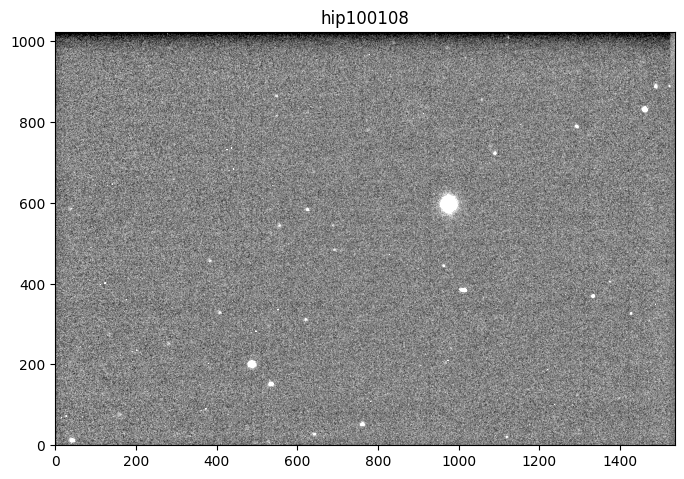

In [8]:
hip100108 = np.median(np.stack([data["hip100108B"], data["hip100108V"]], axis=0), axis=0)
lo,up= np.percentile(hip100108,1),np.percentile(hip100108,99)

plt.figure(figsize=(8, 8))
plt.imshow(hip100108, cmap='gray', origin='lower', clim=(lo,up))
plt.title(f"hip100108")
plt.show()

In [ ]:
# Check data types
print("hip100108B data type:", data["hip100108B"].dtype)
print("hip100108V data type:", data["hip100108V"].dtype)

# Check image dimensions
print("hip100108B shape:", data["hip100108B"].shape)
print("hip100108V shape:", data["hip100108V"].shape)

# Get 2D FWHM

Found 12 stars in image hip100108B


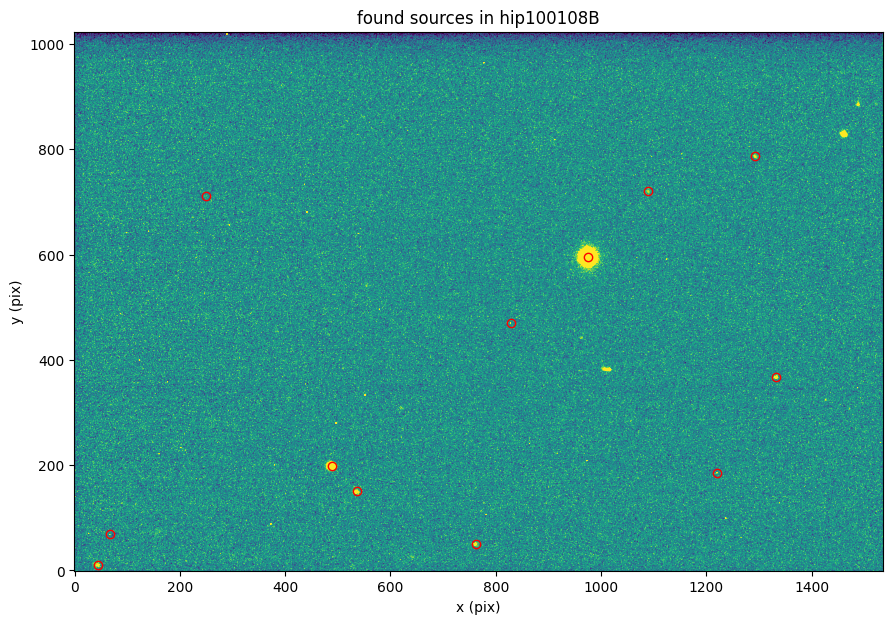

     x-FWHM 5.360666769697656+/-0.0 (pix) for this hip100108B 
     y-FWHM 6.124597396343335+/-0.0 (pix) for this hip100108B 
     FWHM 5.742632083020495+/-0.0 (pix) for this hip100108B 
Found 25 stars in image hip100108V


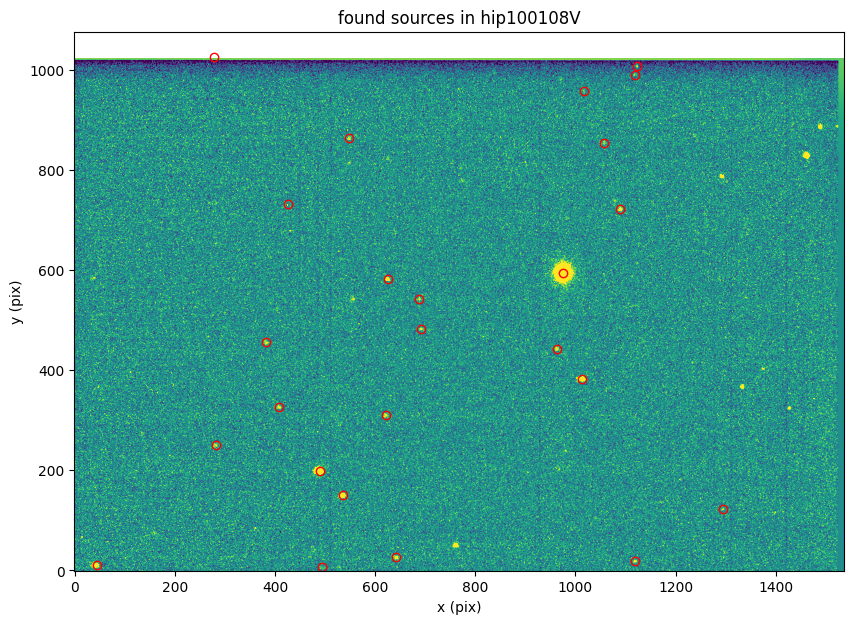

     x-FWHM 5.157483224969384+/-0.0 (pix) for this hip100108V 
     y-FWHM 5.6063336441329+/-0.0 (pix) for this hip100108V 
     FWHM 5.381908434551142+/-0.0 (pix) for this hip100108V 


In [9]:
xfwhms = {}
yfwhms = {}
fwhms = {}
for key, image in data.items():
    mean, median, std = sigma_clipped_stats(image,sigma=3.0,maxiters=5)
    ## Find stars
    daofind = DAOStarFinder(fwhm=15, threshold=6.0*std)  ##peakmax to exclude saturated stars!!
    sources = daofind(image - median)
    print(f"Found {len(sources)} stars in image {key}")

    #Plot stars found
    fig = plt.figure(figsize=(12,7))
    l1 = np.percentile(image[np.isfinite(image)].flatten(), 1)
    l2 = np.percentile(image[np.isfinite(image)].flatten(), 99)
    plt.imshow(image,clim=(l1,l2),origin='lower')
    plt.plot(sources["xcentroid"],sources["ycentroid"],'or',mfc='none')
    plt.title(f"found sources in {key}")
    plt.xlabel("x (pix)")
    plt.ylabel("y (pix)")
    plt.show()

    ## Take nbright brightest stars 
    nbright = 1
    brightest = np.argsort(sources['flux'])[::-1][0:nbright]
    brsources = sources[brightest]

    ##########
    #get fwhm
    rmax = 25
    (ny,nx) = np.shape(image)
    from astropy.modeling import models,fitting
    fit_g = fitting.LevMarLSQFitter()
    allxfwhm, allyfwhm = np.zeros(len(brsources)),np.zeros(len(brsources))
    allfwhm,alltheta = np.zeros(len(brsources)),np.zeros(len(brsources))
    for i,src in enumerate(brsources):
        if int(src['ycentroid']) > rmax and int(src['ycentroid']) < ny-rmax and \
            int(src['xcentroid']) > rmax and int(src['xcentroid']) < nx-rmax:
            img = image[int(src['ycentroid'])-rmax:int(src['ycentroid'])+rmax,
                        int(src['xcentroid'])-rmax:int(src['xcentroid'])+rmax]
            subx,suby = np.indices(img.shape) # instead of meshgrid
            p_init = models.Gaussian2D(amplitude=np.max(img),x_mean=rmax,y_mean=rmax,x_stddev=1.0,y_stddev=1.0)
            fitgauss = fit_g(p_init, subx, suby, img - np.min(img))
            allxfwhm[i] = np.abs(fitgauss.x_stddev.value)
            allyfwhm[i] = np.abs(fitgauss.y_stddev.value)
            allfwhm[i] = 0.5*(allxfwhm[i]+allyfwhm[i])
            alltheta[i] = fitgauss.theta.value
    xfwhm,yfwhm = np.median(allxfwhm)*gaussian_sigma_to_fwhm,np.median(allyfwhm)*gaussian_sigma_to_fwhm
    fwhm = np.median(allfwhm)*gaussian_sigma_to_fwhm
    sigfwhm, sigxfwhm, sigyfwhm = np.std(allfwhm), np.std(allxfwhm), np.std(allyfwhm)
    medtheta = np.median(alltheta)
    print(f"     x-FWHM {xfwhm}+/-{sigxfwhm} (pix) for this {key} ")
    print(f"     y-FWHM {yfwhm}+/-{sigyfwhm} (pix) for this {key} ")
    print(f"     FWHM {fwhm}+/-{sigfwhm} (pix) for this {key} ")

    fwhms[key] = fwhm
    xfwhms[key] = xfwhm
    yfwhms[key] = yfwhm


# 2d gaussians

In [10]:
twodgauss = {}
psf_models = {}
for key, image in data.items():
    twodgauss[key] =  models.Gaussian2D(x_stddev=xfwhms[key]/gaussian_sigma_to_fwhm,
                                        y_stddev=yfwhms[key]/gaussian_sigma_to_fwhm,
                                        )
    
    #twodgauss[key].xname = 'x'
    #twodgauss[key].yname = 'y'
    #twodgauss[key].fluxname = 'amplitude'

    psf_models[key] = prepare_psf_model(twodgauss[key],xname='x_mean',yname='y_mean',fluxname='amplitude')


    

# Find point sources more accuretly with FWHM
more stars found this way:)

In [11]:
fwhms

{'hip100108B': 5.742632083020495, 'hip100108V': 5.381908434551142}

Found 15 stars in image hip100108B


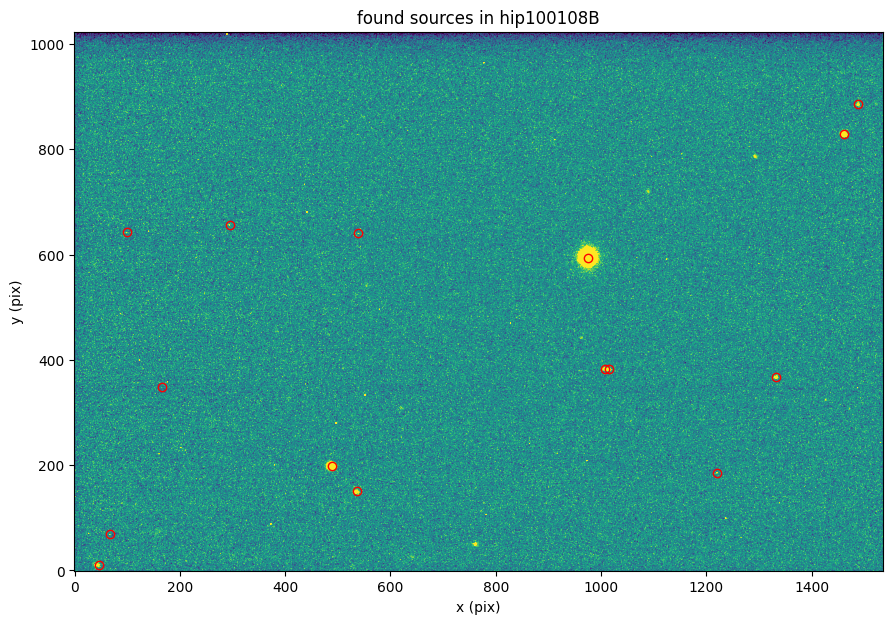

Found 102 stars in image hip100108V


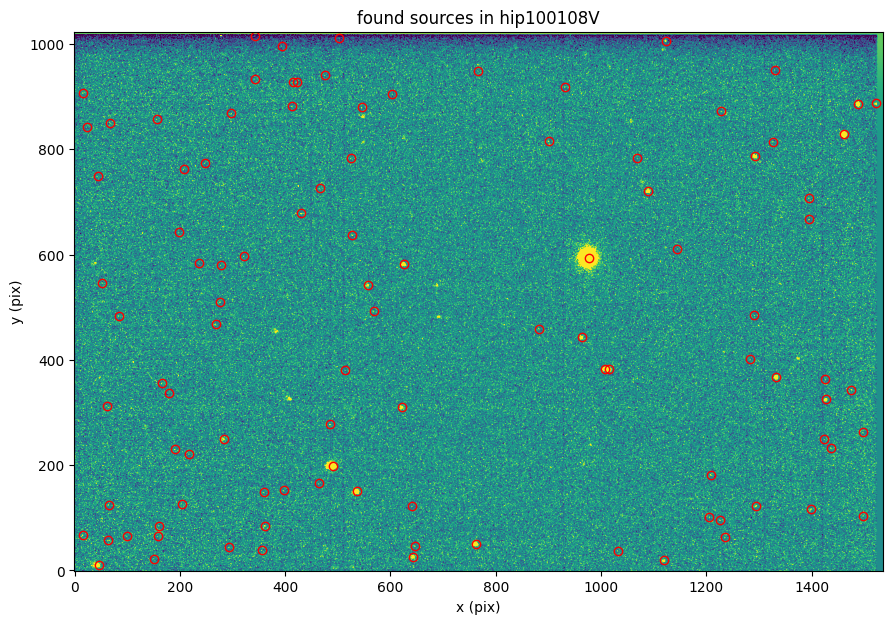

In [41]:
x_inits = {}
y_inits = {}

daofinds = {}

for key, image in data.items():

    mean, median, std = sigma_clipped_stats(image,sigma=3.0,maxiters=5)
    ## Find stars
    daofind = DAOStarFinder(fwhm=fwhms[key], threshold=5*std)  ##peakmax to exclude saturated stars!!
    sources = daofind(image - median)
    print(f"Found {len(sources)} stars in image {key}")

    daofinds[key]=daofind

    #Plot stars found
    fig = plt.figure(figsize=(12,7))
    l1 = np.percentile(image[np.isfinite(image)].flatten(), 1)
    l2 = np.percentile(image[np.isfinite(image)].flatten(), 99)
    plt.imshow(image,clim=(l1,l2),origin='lower')
    plt.plot(sources["xcentroid"],sources["ycentroid"],'or',mfc='none')
    plt.title(f"found sources in {key}")
    plt.xlabel("x (pix)")
    plt.ylabel("y (pix)")
    plt.show()

    ## Take nbright brightest stars and save
    nbright = 1
    brightest = np.argsort(sources['flux'])[::-1][0:nbright]
    brsources = sources[brightest]

    x_inits[key] = brsources['xcentroid']
    y_inits[key] = brsources['ycentroid']



# Iterative PSF Photometry :)


In [42]:
fwhms

{'hip100108B': 5.742632083020495, 'hip100108V': 5.381908434551142}

In [43]:
x_inits[key].value[0]

976.4609475194598

In [46]:
phots = {}

for key, image in data.items():

    group = SourceGrouper(fwhms[key])
    PSF = PSFPhotometry(
        grouper=group ,     
        psf_model=IntegratedGaussianPRF(sigma=fwhms[key]/gaussian_sigma_to_fwhm),
        finder=daofinds[key],
        fit_shape=(3,3), #play with this, this may be small
        aperture_radius=5 ,#play with this as well
        fitter_maxiters=500
    )
    init_params = QTable()
    init_params['x'] = x_inits[key]
    init_params['y'] = y_inits[key]

    phots[key] = PSF(image, 
                        #init_params = init_params,
                        error=np.sqrt(np.square(bkg_uncs[key])+np.square(error[key])), 
                )

In [51]:
phots['hip100108B']

<QTable length=15>
  id  group_id local_bkg ...          qfit                   cfit          flags
int64  int64    float64  ...        float64                float64         int64
----- -------- --------- ... --------------------- ----------------------- -----
    1        1       0.0 ...   0.00897301113478534   0.0007097870149101942     0
    2        2       0.0 ...   0.04585015310606176     0.01913557028006834     0
    3        3       0.0 ...   0.00372235942588597   0.0003967916283512919     0
    4        4       0.0 ...   0.01007848916988119    0.002631115729250616     0
    5        5       0.0 ...  0.000247625743146419   3.682360711234586e-05     0
    6        6       0.0 ...    0.0886784915827712     0.02050152447401803     0
    7        7       0.0 ...  0.004790919041225433  -0.0007382918679631527     0
    8        8       0.0 ...   0.00706069621667184  -0.0004991316056816188     0
    9        9       0.0 ...  0.004130360965930428 -0.00020146983805598267     0
   10       10       0.0 ... 1.036762954913566e-06 -1.3431167135905045e-07     0
   11       11       0.0 ...   0.03298860981165491    0.017853175670471032     0
   12       12       0.0 ...  0.019069914511299184    0.008747525067200142     0
   13       13       0.0 ...  0.044186111713669936    0.019771567950889964     0
   14       14       0.0 ... 0.0010075695909801665   0.0001453645917863422     0
   15       15       0.0 ...  0.012665654038070078 -2.2503431097566288e-07     0

In [48]:
B = phots['hip100108B'].to_pandas()
V = phots['hip100108V'].to_pandas()

B = B.loc[B['flux_fit'].idxmax()]
V = V.loc[V['flux_fit'].idxmax()]


In [49]:
inc = 1
if abs(B['x_fit']-V['x_fit'])>inc or abs(B['y_fit']-V['y_fit'])>inc:
    print("Something's wrong")

In [53]:
V_dt = 1 #s
B_dt = 2 #s

print(f"B flux/s = {B['flux_fit']/B_dt} +/- {B['flux_err']/B_dt}")
print(f"V flux/s = {V['flux_fit']/V_dt} +/- {V['flux_err']/V_dt}")


B flux/s = 330820.59322830575 +/- 26027.889649890487
V flux/s = 706937.6199424627 +/- 54329.532996867296
